In [34]:
import numpy as np
import mne
import pyxdf
import pprint
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *


%load_ext autoreload
%autoreload 2

%load_ext autoreload
%autoreload 2

DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in xdf file(s)

In [35]:
# Read data
streams, header = pyxdf.load_xdf(DATA_FILE)

In [36]:
# Extract streams from xdf data

def find_stream(name, streams):
    for stream in streams:
        if stream['info']['name'][0] == name:
            return stream
    
    print(f'Error: stream "{name}" not found')

unicorn_stream = find_stream('Unicorn', streams)
fs = int(unicorn_stream['info']['nominal_srate'][0]) # 250 Hz

openvibe_stream = find_stream('openvibeMarkers', streams)
openvibe_stream['time_series'] = np.array(openvibe_stream['time_series'])

print(f"EEG data shape: {unicorn_stream['time_series'].shape}")
print(f"Markers shape: {openvibe_stream['time_series'].shape}")
print(f'Sampling Frequency: {fs}')

EEG data shape: (1023780, 17)
Markers shape: (1213, 1)
Sampling Frequency: 250


# Extract Event Data

From the Open Vibe Marker Stream

- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event

The mapping for this particular paradigm was:
- 'beep': 0, 
- 'cue_no_blink': 1, 
- 'imagery_no_blink': 2, 
- 'break': 3, 
- 'cue_handR': 4, 
- 'imagery_handR': 5, 
- 'cue_handL': 6, 
- 'imagery_handL': 7

In [37]:
def unique(input_list):
    unique_items = []
    for x in input_list:
        if x not in unique_items:
            unique_items.append(x)
    
    return unique_items

def build_unique_mapping(unique_labels):
    unique_mapping = {}
    for i, label in enumerate(unique_labels):
        unique_mapping[label] = i
    
    return unique_mapping

In [38]:
# Get event codes
event_labels = [x[0] for x in openvibe_stream['time_series']]
unique_labels = unique(event_labels)
label2code = build_unique_mapping(unique_labels)
event_codes = np.array([label2code[x] for x in event_labels])

# Get event time stamps
event_time_stamps = np.array(openvibe_stream['time_stamps'])

assert event_time_stamps.shape == event_codes.shape

print(f'Total number of events: {event_codes.shape[0]}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for left MI: {label2code["imagery_handR"]}')
print(f'Number of left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Number of right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

Total number of events: 1213
Event code for left MI: 7
Event code for left MI: 5
Number of left MI events: 200
Number of right MI events: 200


# Preprocess EEG data

In [39]:
# Extract the relevent EEG channels
eeg_data = unicorn_stream['time_series'][:,0:8].T
eeg_data.shape

(8, 1023780)

## Rereference the EEG data

In [40]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## Filter EEG data

In [41]:
lf = 8
hf = 16
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

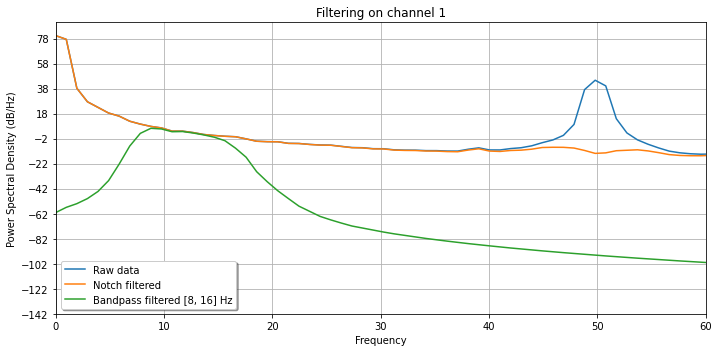

In [42]:
channel_number = preprocess.name2channel('C3')

# Show the effect of the filter
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')
plt.psd(eeg_data[channel_number], Fs=fs, label='Raw data')
plt.psd(eeg_notched[channel_number], Fs=fs, label='Notch filtered')
plt.psd(eeg_notched_bp[channel_number], Fs=fs, label=f'Bandpass filtered [{lf}, {hf}] Hz')
plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

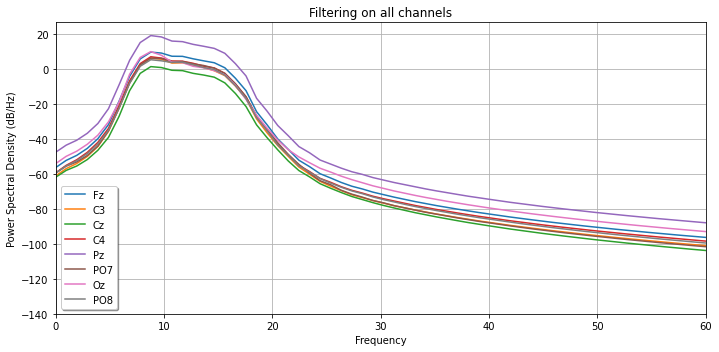

In [43]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [44]:
eeg_timestamps = unicorn_stream['time_stamps']
eeg_start_time = eeg_timestamps[0]
label_start_time = event_time_stamps[0]
experiment_start_time = min(label_start_time, eeg_start_time)

relative_eeg_timestamps = eeg_timestamps - experiment_start_time
relative_event_time_stamps = event_time_stamps - experiment_start_time

In [45]:
def find_closest_time(timestamp, eeg_timestamps):
    return np.where(eeg_timestamps > timestamp)[0][0]

In [46]:
# Get indices of events
indices = [0]

for timestamp in relative_event_time_stamps:
    indices.append(find_closest_time(timestamp, relative_eeg_timestamps))

# Build event time series (use -1 since 0 is actually a code for no blinking)
event_time_series = np.zeros_like(eeg_timestamps) - 1

for i, (_, code) in enumerate(zip(indices[1:], event_codes)):
    idx = i+1
    if idx < len(indices)-1:
        event_time_series[indices[idx]:indices[idx+1]] = code
    else:
        event_time_series[indices[idx]:] = code

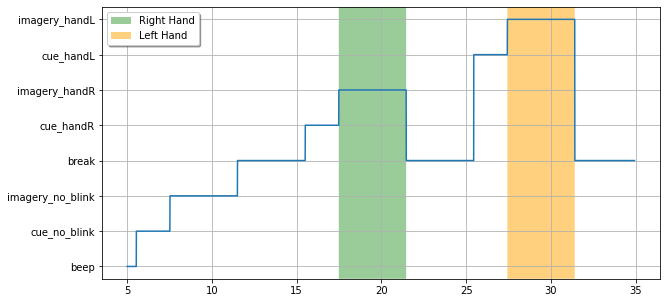

In [47]:
window = 30
start_time = 5
t = np.arange(0, window*fs, 1/fs)

fig, ax = plt.subplots(figsize=(10,5))
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]
ax.plot(x, y, '-')

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.grid()
plt.legend(shadow=True)
plt.show()

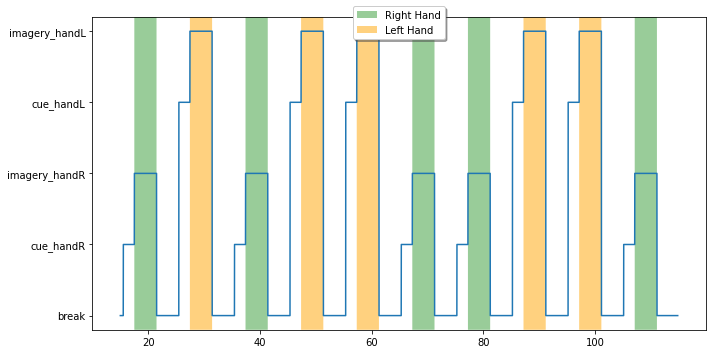

In [15]:
window = 100
start_time = 15
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.ylim([2.8,7.2])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, fancybox=True)
plt.tight_layout()
plt.show()

# Normalise EEG data

In [16]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)

# Inspect EEG data with markers

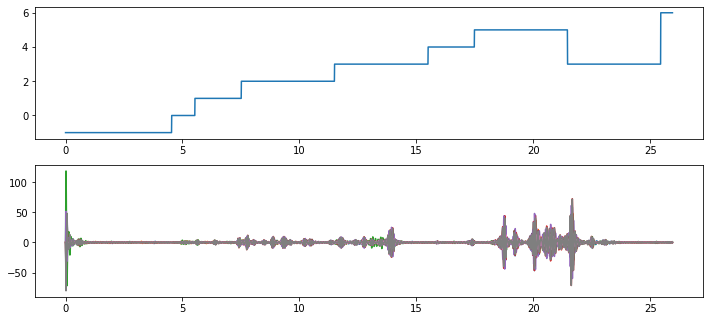

In [17]:
window = 26
start_time = 0
number_of_channels = 8

plt.subplots(figsize=(10,20), sharex=True)
plt.tight_layout()

x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y1 = event_time_series[start_time*fs:(start_time + window)*fs]
plt.subplot((number_of_channels + 1),1,1)
plt.plot(x, y1)

for i in range(number_of_channels):
    y2 = eeg_notched_bp_norm[i ,start_time*fs:(start_time + window)*fs]
    plt.subplot((number_of_channels + 1), 1, 2)
    plt.plot(x, y2)

plt.show()

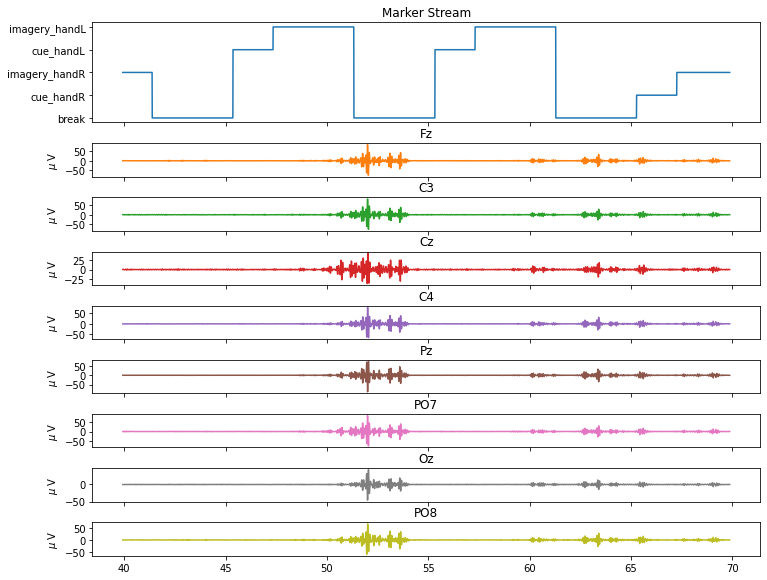

In [18]:
def plot_all(eeg_timestamps, event_time_series, eeg_data, number_of_channels=None, window=30, start_time = 15):

    if number_of_channels == None:
        number_of_channels = eeg_data.shape[0]

    colors = plt.rcParams["axes.prop_cycle"]()

    height_ratios = [1 if i>0 else 3 for i in range(number_of_channels+1)]

    fig, axs = plt.subplots(
        number_of_channels+1, 1,
        figsize=(10,8), 
        sharex=True, 
        gridspec_kw={'height_ratios': height_ratios}
    )
    plt.tight_layout()

    x = eeg_timestamps[start_time*fs:(start_time + window)*fs]
    y = event_time_series[start_time*fs:(start_time + window)*fs]

    c = next(colors)["color"]
    axs[0].plot(x, y, color=c)
    axs[0].set_title('Marker Stream')
    plt.sca(axs[0])
    plt.yticks(range(len(event_labels)), event_labels)
    axs[0].set_ylim([2.8,7.2])

    for i in range(number_of_channels):
        axs[i+1].plot(
            x, 
            eeg_data[i ,start_time*fs:(start_time + window)*fs], 
            color=next(colors)["color"]
        )
        axs[i+1].set_title(preprocess.channel2name(i))
        axs[i+1].set_ylabel(r'$\mu$ V')

    plt.show()

plot_all(relative_eeg_timestamps, event_time_series, eeg_notched_bp_norm, start_time=40)

# Save the data

In [19]:
data_file_name = DATA_FILE_NAME.split('.')[0]
np.save(DATA_DIR / f'{data_file_name}_eeg_data', eeg_notched_bp, allow_pickle=True)
np.save(DATA_DIR / f'{data_file_name}_marker_stream', eeg_notched_bp, allow_pickle=True)

# ICA Experiment

In [20]:
# from sklearn.decomposition import FastICA

# transformer = FastICA(n_components=7, random_state=0, whiten=True)


# _transformed = transformer.fit_transform(eeg_notched_bp.T)
# _transformed.shape

# plot_all(relative_eeg_timestamps, event_time_series, _transformed.T, window=5, number_of_channels=7)

# Split into trials

In [21]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR', 'cue_handL', 'cue_handR']
Class codes: [7, 5, 6, 4]
Number of classes: 4


In [22]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')

(8, 500, 200) (8, 500, 200)
(8, 500, 200) (8, 500, 200)


# Define idle and MI trials

We now combine the trials for the classes 'cue_handL' and 'cue_handR' into one 'idle' class. Likewise, 'imagery_handL' and 'imagery_handR' are combined into the class 'mi'.

('cue_handL', 'cue_handR') &#8594; 'idle'

('imagery_handL', 'imagery_handR') &#8594; 'mi'

In [23]:

trials['idle'] = np.concatenate((trials['cue_handL'], trials['cue_handR']), axis=2)
trials['mi'] = np.concatenate((trials['imagery_handL'], trials['imagery_handR']), axis=2)
print(trials['idle'].shape, trials['mi'].shape)

(8, 500, 400) (8, 500, 400)


# Some statistical Analysis to remove noisy trials - for MI vs idle

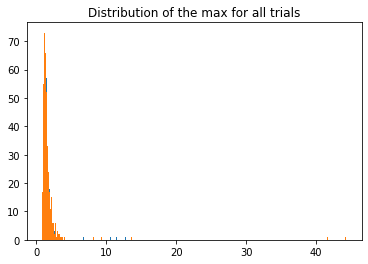

In [24]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for all trials')
plt.hist(trials['idle'].max(axis = (0,1)), bins='auto', label='Idle Trials')
plt.hist(trials['mi'].max(axis = (0,1)), bins='auto', label='MI Trials')
plt.show()

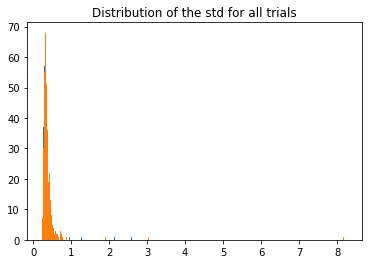

In [25]:
plt.figure()
plt.title('Distribution of the std for all trials')
plt.hist(trials['idle'].std(axis = (0,1)), bins='auto', label='idle Trials')
plt.hist(trials['mi'].std(axis = (0,1)), bins='auto', label='MI Trials')
plt.show()

In [26]:
# remove bad trials

good_trials = {
    'idle': np.zeros((nchannels, nsamples,1)),
    'mi': np.zeros((nchannels, nsamples,1)),
} 

for trial in range(trials['idle'].shape[2]):
    eeg_sampleL = trials['idle'][:,:,trial]
    if eeg_sampleL.std(axis = (0,1)) < 0.7 and eeg_sampleL.max(axis = (0,1)) < 4:
        good_trials['idle'] = np.concatenate(
            [good_trials['idle'], np.expand_dims(eeg_sampleL, -1)],
            axis=2
        )

    eeg_sampleR = trials['mi'][:,:,trial]
    if eeg_sampleR.std(axis = (0,1)) < 0.7 and eeg_sampleR.max(axis = (0,1)) < 4:
        good_trials['mi'] = np.concatenate(
            [good_trials['mi'], np.expand_dims(eeg_sampleR, -1)],
            axis=2
        )

good_trials['idle'] = good_trials['idle'][:,:,1:]
good_trials['mi'] = good_trials['mi'][:,:,1:]

print(good_trials['idle'].shape)
print(good_trials['mi'].shape)

(8, 500, 392)
(8, 500, 388)


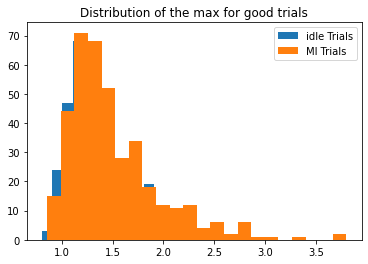

In [27]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for good trials')
plt.hist(good_trials['idle'].max(axis = (0,1)), bins='auto', label='idle Trials')
plt.hist(good_trials['mi'].max(axis = (0,1)), bins='auto', label='MI Trials')
plt.legend()
plt.show()

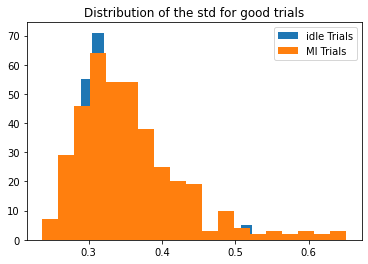

In [28]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the std for good trials')
plt.hist(good_trials['idle'].std(axis = (0,1)), bins='auto', label='idle Trials')
plt.hist(good_trials['mi'].std(axis = (0,1)), bins='auto', label='MI Trials')
plt.legend()
plt.show()

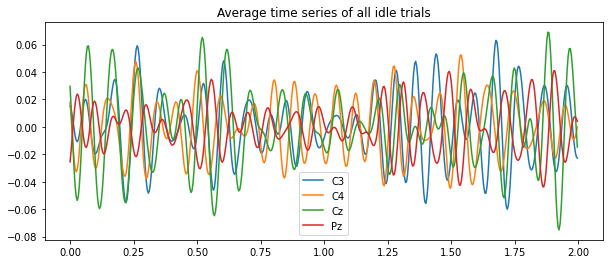

In [29]:
av_left_trials = trials['idle'].mean(axis = 2)
av_left_trials.shape
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[preprocess.name2channel(name)], label=name)
    
plt.title('Average time series of all idle trials')
plt.legend()
plt.show()

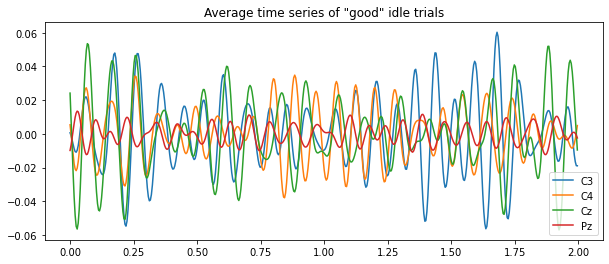

In [30]:
av_left_trials = good_trials['idle'].mean(axis = 2)
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[preprocess.name2channel(name)], label=name)
    
plt.title('Average time series of "good" idle trials')
plt.legend()
plt.show()

# Noisy trial removal for left and right MI

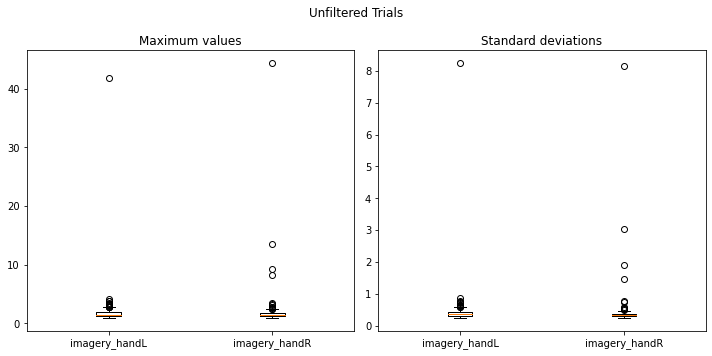

In [31]:
classes = ['imagery_handL', 'imagery_handR']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

In [32]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

{'imagery_handL': 0.6310728339496134, 'imagery_handR': 0.5600038135652317}

In [33]:
good_trials = get_good_trials(
    trials=trials,
    nchannels=nchannels,
    class_nsamples=class_nsamples,
    upperlimit_std=upperlimit_std,
    upperlimit_max=upperlimit_max
)

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')


NameError: name 'class_nsamples' is not defined

# Analysis

In [ ]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_labs)
print('Class codes:', cl_codes)
print('Number of classes:', nclasses)

cl0 = 'idle'
cl1 = 'mi'


Redefine cl_labs such that it contains the new two classes of interest:

In [ ]:
cl_labs = ['idle', 'mi']

In [ ]:
psd0, freqs, = analysis.psd(trials[cl0], nchannels, nsamples, fs)
psd1, freqs, = analysis.psd(good_trials[cl1], nchannels, nsamples, fs)
trials_PSD = {
    cl0: psd0, 
    cl1: psd1
}

analysis.plot_psd(
    trials_PSD,
    freqs,
    [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
    chan_lab=['left (C3)', 'center', 'right'],
    maxy=0.05
)

In [ ]:
trials_logvar = {
    cl0: analysis.logvar(good_trials[cl0]),
    cl1: analysis.logvar(good_trials[cl1])
}

analysis.plot_logvar(trials_logvar, nchannels, cl_labs)

### CSP
Using CSP generates components which are easier to classify than the channels. 

Instead of 8 channels, we now have 8 mixtures of channels, called components. They are the result of 8 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot.

In [ ]:
csp = preprocess.CSP(good_trials, cl_labs, nsamples, nchannels)
trials_csp = csp.get_csp_trials()

trials_csp_logvar = {
    cl0: analysis.logvar(trials_csp[cl0]),
    cl1: analysis.logvar(trials_csp[cl1])
}
analysis.plot_logvar(trials_csp_logvar, nchannels, cl_labs)

In [ ]:
psd0, freqs, = analysis.psd(trials_csp[cl0], nchannels, nsamples, fs)
psd1, freqs, = analysis.psd(trials_csp[cl1], nchannels, nsamples, fs)
trials_csp_PSD = {
    cl0: psd0, 
    cl1: psd1
}

analysis.plot_psd(
    trials_csp_PSD,
    freqs,
    [0,3,-1],
    chan_lab=['first component', 'middle component', 'last component'],
    maxy=0.22
)

In [ ]:
analysis.plot_scatter(trials_csp_logvar[cl0], trials_csp_logvar[cl1], cl_labs)

## LDA

Check whether we have the same number of trials for each class, otherwise drop some of the class with more samples.

In [ ]:
print(good_trials[cl0].shape)
print(good_trials[cl1].shape)

if good_trials[cl0].shape[2] != good_trials[cl1].shape[2]:
    min_trials = min(good_trials[cl0].shape[2], good_trials[cl1].shape[2])
    max_trials = max(good_trials[cl0].shape[2], good_trials[cl1].shape[2])
    good_trials[cl0] = good_trials[cl0][:,:,0:min_trials]
    good_trials[cl1] = good_trials[cl1][:,:,0:min_trials]
    print("Dropping " + str(max_trials-min_trials) + " trials.")
    
print(good_trials[cl0].shape)
print(good_trials[cl1].shape)

In [ ]:
train_percentage = 0.8


# Calculate the number of trials for each class the above percentage boils down to
ntrain_cl0 = int(good_trials[cl0].shape[2] * train_percentage)
ntrain_cl1 = int(good_trials[cl1].shape[2] * train_percentage)
ntest_cl0 = good_trials[cl0].shape[2] - ntrain_cl0
ntest_cl1 = good_trials[cl1].shape[2] - ntrain_cl1

print(f'Training datapoints: ({cl0}: {ntrain_cl0}; {cl1}: {ntrain_cl1})')
print(f'Testing datapoints: ({cl0}: {ntest_cl0}; {cl1}: {ntest_cl1})')

In [ ]:
# Splitting the filtered and cleaned signal into a train and test set
train = {
    cl0: good_trials[cl0][:,:,:ntrain_cl0],
    cl1: good_trials[cl1][:,:,:ntrain_cl1]
}

test = {
    cl0: good_trials[cl0][:,:,ntrain_cl0:],
    cl1: good_trials[cl1][:,:,ntrain_cl1:]
}

print(f'Training dataset: ({cl0}: {train[cl0].shape}; {cl1}: {train[cl0].shape})')
print(f'Testing dataset: ({cl0}: {test[cl0].shape}; {cl1}: {test[cl1].shape})')

In [ ]:
train_csp = preprocess.CSP(train, cl_labs, nsamples, nchannels)
train_csp_components = train_csp.get_csp_trials()
W = train_csp.get_W()
print(W.shape)
print(train_csp_components[cl0].shape)

test_csp = preprocess.CSP(test, cl_labs, nsamples, nchannels, W=W)
test_csp_components = test_csp.get_csp_trials()
print(test_csp_components[cl0].shape)

In [ ]:
train_csp_logvar = {
    cl0: analysis.logvar(train_csp_components[cl0]),
    cl1: analysis.logvar(train_csp_components[cl1])
}
test_csp_logvar = {
    cl0: analysis.logvar(test_csp_components[cl0]),
    cl1: analysis.logvar(test_csp_components[cl1])
}

print(train_csp_logvar[cl0].shape)

analysis.plot_logvar(train_csp_logvar, nchannels, cl_labs)

In [ ]:
# Select only the first and last components for classification
comp = np.array([0,-1])

train_csp_selection = {
    cl0: train_csp_components[cl0][comp,:,:],
    cl1: train_csp_components[cl1][comp,:,:]
}
print(train_csp_selection[cl0].shape)

test_csp_selection = {
    cl0: test_csp_components[cl0][comp,:,:],
    cl1: test_csp_components[cl1][comp,:,:]
}
print(test_csp_selection[cl0].shape)

# Recalculate the log-var
train_csp_logvar = {
    cl0: analysis.logvar(train_csp_selection[cl0]),
    cl1: analysis.logvar(train_csp_selection[cl1])
}
print(train_csp_logvar[cl0].shape)

test_csp_logvar = {
    cl0: analysis.logvar(test_csp_selection[cl0]),
    cl1: analysis.logvar(test_csp_selection[cl1])
}


analysis.plot_logvar(train_csp_logvar, nchannels, cl_labs)
analysis.plot_logvar(test_csp_logvar, nchannels, cl_labs)

In [ ]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [ ]:
W,b = train_lda(train_csp_logvar[cl0].T, train_csp_logvar[cl1].T)

print('W:', W)
print('b:', b)

In [ ]:
# Scatterplot like before
analysis.plot_scatter(train_csp_logvar[cl0], train_csp_logvar[cl1], cl_labs)

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

In [ ]:
analysis.plot_scatter(test_csp_logvar[cl0], test_csp_logvar[cl1], cl_labs)
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

In [ ]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(test_csp_logvar[cl0], W, b) == 1).sum(), 
    (apply_lda(test_csp_logvar[cl1], W, b) == 1).sum()],
    [(apply_lda(test_csp_logvar[cl0], W, b) == 2).sum(), 
    (apply_lda(test_csp_logvar[cl1], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

## Replicate results with sklearn 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.metrics import confusion_matrix

In [ ]:
print(train_csp_logvar[cl0].shape)
print(train_csp_logvar[cl1].shape)

In [ ]:
# Train
X_cl0 = train_csp_logvar[cl0].T
y_cl0 = np.zeros(X_cl0.shape[0])
X_cl1 = train_csp_logvar[cl1].T
y_cl1 = np.ones(X_cl0.shape[0])

X_train = np.concatenate([X_cl0, X_cl1], axis=0)
y_train = np.concatenate([y_cl0, y_cl1], axis=0)

print(X_train.shape, y_train.shape)

# Test
X_cl0 = test_csp_logvar[cl0].T
y_cl0 = np.zeros(X_cl0.shape[0])
X_cl1 = test_csp_logvar[cl1].T
y_cl1 = np.ones(X_cl0.shape[0])

X_test = np.concatenate([X_cl0, X_cl1], axis=0)
y_test = np.concatenate([y_cl0, y_cl1], axis=0)
print(X_test.shape, y_test.shape)

In [ ]:
clf_lda = skLDA()
clf_lda.fit(X_train, y_train)

ypred = clf_lda.predict(X_test)

print(f'LDA Accuracy: {np.sum(ypred == y_test) / ypred.size}')

print(confusion_matrix(y_test, ypred))

In [ ]:
y_train_pred = clf_lda.predict(X_train)
print(f'LDA Accuracy: {np.sum(y_train_pred == y_train) / y_train_pred.size}')


In [ ]:
# Try out an SVM

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

print(f'SVM Accuracy: {np.sum(y_pred == y_test) / y_pred.size}')
print(confusion_matrix(y_test, y_pred))

## Using Cross validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = np.concatenate([X_test, X_train], axis=0)
y = np.concatenate([y_test, y_train], axis=0)
print('All', X.shape,y.shape)

cv = 5

In [ ]:
# SVM
clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)

print(f'SVM mean score for {cv} folds: {scores.mean()}')

In [ ]:
# LDA
clf_lda = skLDA()
scores = cross_val_score(clf_lda, X, y, cv=5)
print(f'LDA mean score for {cv} folds: {scores.mean()}')